# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import STL
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA
from utilsforecast.plotting import plot_series
from datetime import date, timedelta
import calendar
from coreforecast.scalers import boxcox_lambda, boxcox, inv_boxcox
from scipy.stats import entropy
import pickle


c:\Users\joana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Conexão

In [2]:
df_daily_filled = pd.read_csv('../df_daily_filled.csv', parse_dates=['detected'], dtype='int32')
df_daily_filled = df_daily_filled.set_index('detected')
df_daily_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-08-01 to 2024-02-29
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   943 non-null    int32
 1   count_2       943 non-null    int32
 2   direction_3   943 non-null    int32
 3   count_3       943 non-null    int32
 4   direction_4   943 non-null    int32
 5   count_4       943 non-null    int32
 6   direction_5   943 non-null    int32
 7   count_5       943 non-null    int32
 8   direction_6   943 non-null    int32
 9   count_6       943 non-null    int32
 10  direction_7   943 non-null    int32
 11  count_7       943 non-null    int32
 12  direction_8   943 non-null    int32
 13  count_8       943 non-null    int32
 14  direction_9   943 non-null    int32
 15  count_9       943 non-null    int32
 16  direction_10  943 non-null    int32
 17  count_10      943 non-null    int32
 18  direction_11  943 non-null    int32
 19  count_11  

In [3]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df_daily_filled.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

            direction_2  count_2  direction_3  count_3  direction_4  count_4  \
detected                                                                       
2021-08-01          219      327          155      323          138      424   
2021-08-02          144      252          194      381          117

In [4]:
#sem variavel exogena
df_daily_filled = df_daily_filled.resample('D').sum()
df_8 = df_daily_filled.filter(['count_8']).reset_index().assign(unique_id = 8)
df_8 = df_8.filter(['unique_id','detected','count_8'])
df_8.columns = ['unique_id','ds','y']
df_8

,unique_id,ds,y
0,8,2021-08-01,106
1,8,2021-08-02,91
2,8,2021-08-03,115
3,8,2021-08-04,104
4,8,2021-08-05,107
...,...,...,...
938,8,2024-02-25,75
939,8,2024-02-26,112
940,8,2024-02-27,137
941,8,2024-02-28,156


In [5]:
def calcular_pascoa(ano):
    """Calcula a data da Páscoa para um dado ano (algoritmo de Meeus/Jones/Butcher)."""
    a = ano % 19
    b = ano // 100
    c = ano % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    mes = (h + l - 7 * m + 114) // 31
    dia = ((h + l - 7 * m + 114) % 31) + 1
    return date(ano, mes, dia)

#feriados 
def calcular_feriados_portugal(anos, incluir_lisboa=False):
    feriados = []

    for ano in anos:
        # Feriados
        feriados += [
            date(ano, 1, 1),   # Ano Novo
            date(ano, 4, 25),  # Dia da Liberdade
            date(ano, 5, 1),   # Dia do Trabalhador
            date(ano, 6, 10),  # Dia de Portugal
            date(ano, 8, 15),  # Assunção de Nossa Senhora
            date(ano, 10, 5),  # Implantação da República
            date(ano, 11, 1),  # Dia de Todos os Santos
            date(ano, 12, 1),  # Restauração da Independência
            date(ano, 12, 8),  # Imaculada Conceição
            date(ano, 12, 25), # Natal
            date(ano, 6, 13),  # Santo António
        ]

        # Feriados Domingo de Páscoa
        pascoa = calcular_pascoa(ano)
        feriados += [
            pascoa - timedelta(days=47), # Carnaval
            pascoa - timedelta(days=2),  # Sexta-feira Santa
            pascoa + timedelta(days=1),  # Segunda-feira de Páscoa 
            pascoa + timedelta(days=60), # Corpo de Deus
        ]

    return set(feriados)


In [6]:
anos = df_daily_filled.index.year.unique()
feriados = calcular_feriados_portugal(anos, incluir_lisboa=True)

df_daily_filled['holiday'] = df_daily_filled.index.date
df_daily_filled['holiday'] = df_daily_filled['holiday'].apply(
    lambda x: 1 if x in feriados else 0
)



In [7]:
#fim de semana
df_daily_filled['weekend'] = df_daily_filled.index.weekday.isin([5, 6]).astype(int)
df_daily_filled['exog'] = ((df_daily_filled['holiday'] == 1) | (df_daily_filled['weekend'] == 1)).astype(int)


In [8]:
#com variavel exogena 
df_8_1 = df_daily_filled[['count_8', 'exog']].reset_index().assign(unique_id=8)
df_8_1.columns = ['ds', 'y', 'X', 'unique_id']
df_8_1 = df_8_1[['unique_id', 'ds', 'y', 'X']].query('ds < "2022-08-01"')
df_8_1

,unique_id,ds,y,X
0,8,2021-08-01,106,1
1,8,2021-08-02,91,0
2,8,2021-08-03,115,0
3,8,2021-08-04,104,0
4,8,2021-08-05,107,0
...,...,...,...,...
360,8,2022-07-27,131,0
361,8,2022-07-28,115,0
362,8,2022-07-29,99,0
363,8,2022-07-30,75,1


# MSTL forecast

In [9]:
#model = AutoARIMA(season_length=7)
model = MSTL(season_length=[356, 7], trend_forecaster=AutoARIMA())

sf = StatsForecast(
    models=[model],
    freq='D',
    n_jobs=-1
)

sf.fit(df_8_1)

# Criar o DataFrame de previsão para o próximo dia
future_dates = pd.date_range(start='2021-08-01', periods= 1, freq='D')
future_exog = pd.DataFrame({
    'ds': future_dates,
    'X': [0]  
})
future_exog['unique_id'] = 8  

# Realizar a previsão
levels=[99.7]
fcst = sf.forecast(df=df_8_1, X_df=future_exog, h=1, level=levels, fitted=True)

# Exibir as previsões
print(fcst)


   unique_id         ds      MSTL  MSTL-lo-99.7  MSTL-hi-99.7
0          8 2022-08-01  88.93084     85.325676     92.535995


In [10]:
# models = [MSTL(season_length = [7])]
# sf = StatsForecast(
#     models=models, 
#     freq='D',
#     n_jobs=-1,
# )

# horizon = 7
# levels = [99] 

# fcst = sf.forecast(df=df_8_1, h=7, level=[99], fitted=True)
# fcst.head()

In [11]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head()


,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
0,8,2021-08-01,106.0,105.923233,102.318069,109.528397
1,8,2021-08-02,91.0,90.303940,86.698776,93.909096
2,8,2021-08-03,115.0,114.747215,111.142059,118.352379
3,8,2021-08-04,104.0,111.544662,107.939499,115.149818
4,8,2021-08-05,107.0,98.333000,94.727844,101.938164


In [12]:
# anomalies = insample_forecasts[~insample_forecasts['y'].between(insample_forecasts['MSTL-lo-99'], insample_forecasts['MSTL-hi-99'])]
# anomalies
anomalies = insample_forecasts[
    ~insample_forecasts['y'].between(
        insample_forecasts.iloc[:,4],
        insample_forecasts.iloc[:,5]
    )
]

anomalies

,unique_id,ds,y,MSTL,MSTL-lo-99.7,MSTL-hi-99.7
3,8,2021-08-04,104.0,111.544662,107.939499,115.149818
4,8,2021-08-05,107.0,98.333000,94.727844,101.938164
5,8,2021-08-06,77.0,72.937019,69.331856,76.542175
8,8,2021-08-09,88.0,82.902519,79.297356,86.507675
9,8,2021-08-10,67.0,62.377251,58.772087,65.982407
356,8,2022-07-23,106.0,96.403748,92.798584,100.008911
357,8,2022-07-24,97.0,92.505409,88.900246,96.110565
359,8,2022-07-26,163.0,154.942505,151.337341,158.547668
360,8,2022-07-27,131.0,139.638641,136.033478,143.243805
361,8,2022-07-28,115.0,119.172577,115.567413,122.777733


In [13]:
plot_series(forecasts_df=insample_forecasts, level=levels, plot_anomalies=True, engine='plotly')

# Função dinamica

In [14]:
def fill_zeros(df_daily_filled, max_weeks_back=5):
    df_filled = df_daily_filled.copy()
    for col in df_daily_filled.columns:
        if col.startswith('count_'):
            zero_dates = df_daily_filled[df_daily_filled[col] == 0].index
            for datetime in zero_dates:
                for weeks_back in range(1, max_weeks_back + 1):
                    prev_week = datetime - pd.Timedelta(weeks=weeks_back)
                    if prev_week in df_daily_filled.index:
                        prev_value = df_daily_filled.loc[prev_week, col]
                        if prev_value != 0:
                            df_filled.loc[datetime, col] = prev_value
                            break
    return df_filled


In [15]:
def aplica_algoritmo(df_daily_filled, contador_id, exog_col='exog',
                     start_date='2021-08-01', end_date='2022-08-01',
                     season_length=[7], n_jobs=-1, datas_corrigidas_previamente=None):
    
    if contador_id is None:
        raise ValueError("É necessário especificar o 'contador_id'.")
    
    if contador_id not in df_daily_filled.columns:
        raise ValueError(f"Contador {contador_id} não encontrado no DataFrame.")
    
    if exog_col not in df_daily_filled.columns:
        raise ValueError(f"Coluna exógena {exog_col} não encontrada no DataFrame.")
    
    if datas_corrigidas_previamente is None:
        datas_corrigidas_previamente = set()
    
    # 1. Filtrar dados históricos até à data limite
    df_hist = df_daily_filled.loc[start_date:end_date].copy()
    df_hist[contador_id] = df_hist[contador_id].astype(float)

    # 2. Substituir dias com zeros 
    df_hist_corr = fill_zeros(df_hist)
    

    # 3. Preparar dados para StatsForecast
    unique_id = contador_id
    df_model = df_hist_corr[[contador_id, exog_col]].reset_index().assign(unique_id=unique_id)
    df_model.columns = ['ds', 'y', 'X', 'unique_id']
    df_model = df_model[['unique_id', 'ds', 'y', 'X']]

    # 4. Ajustar o modelo
    model = MSTL(season_length=season_length, trend_forecaster=AutoARIMA())
    sf = StatsForecast(models=[model], freq='D', n_jobs=n_jobs)
    sf.fit(df_model)
    
    
    # 5. Previsão (1 dia à frente apenas, para completar fitting)
    future_dates = pd.date_range(start=df_model['ds'].max() + pd.Timedelta(days=1), periods=1, freq='D')
    future_exog_values = [1 if d.date() in feriados else 0 for d in future_dates]

    future_exog = pd.DataFrame({
        'ds': future_dates,
        'X': future_exog_values,
        'unique_id': [contador_id] * len(future_dates)      
    })

    levels=[99.7]
    sf.forecast(df=df_model, X_df=future_exog, h=1, level=levels, fitted=True)

    # 6. Obter previsões in-sample e identificar outliers
    insample_fcst = sf.forecast_fitted_values()
    insample_fcst.columns = ['unique_id', 'ds', 'y', 'fitted', 'lo_99_7', 'hi_99_7']

    anomalies = insample_fcst[
        ~insample_fcst['y'].between(insample_fcst['lo_99_7'], insample_fcst['hi_99_7'])
    ].copy()

    novas_datas_corrigidas = set()

    # 7. Corrigir anomalias
    for _, row in anomalies.iterrows():
        dia = row['ds']
        
        if dia in datas_corrigidas_previamente or dia in novas_datas_corrigidas:
            continue

        y = row['y']
        hi = row['hi_99_7']
        lo = row['lo_99_7']
        historico = df_hist_corr.loc[df_hist_corr.index < dia, contador_id]

        if historico.empty:
            continue

        max_hist = historico.max()

        if y > hi:
            novo_valor = min(hi, max_hist)
        elif y < lo:
            novo_valor = lo
        else:
            continue

        df_hist_corr.loc[dia, contador_id] = novo_valor
        novas_datas_corrigidas.add(dia)


    # 9. Retornar histórico corrigido, anomalias, datas corrigidas e componente semanal
    return df_hist_corr, anomalies, novas_datas_corrigidas



In [16]:
#para um periodo de 2 semanas no maximo: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added, max_weeks=2):
#     if weeks_added >= max_weeks:
#         return df_hist, weeks_added, False

#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)
#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True


# para todos os dados: 

# def get_one_more_week(df_daily_filled, df_hist, weeks_added):
#     last_date = df_hist.index.max()
#     next_week_start = last_date + pd.Timedelta(days=1)
#     next_week_end = next_week_start + pd.Timedelta(days=6)

#     df_next_week = df_daily_filled.loc[next_week_start:next_week_end]

#     if df_next_week.empty:
#         return df_hist, weeks_added, False

#     df_hist_updated = pd.concat([df_hist, df_next_week])
#     return df_hist_updated, weeks_added + 1, True



# Rolling windows (janela deslizante), avança de uma semana e elimina uma semana do inicio
def get_one_more_week_rolling(df, df_hist, weeks_added, janela_semanas=52):
    last_date = df_hist.index.max()
    next_week_start = last_date + pd.Timedelta(days=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    df_next_week = df.loc[next_week_start:next_week_end]

    if df_next_week.empty:
        return df_hist, weeks_added, False

    # Concatenar nova semana
    df_hist_updated = pd.concat([df_hist, df_next_week])

    # Manter janela de tamanho fixo (em semanas)
    dias_janela = janela_semanas * 7
    min_date = df_hist_updated.index.max() - pd.Timedelta(days=dias_janela - 1)
    df_hist_updated = df_hist_updated[df_hist_updated.index >= min_date]

    return df_hist_updated, weeks_added + 1, True


In [17]:
# # Dicionários para guardar resultados de cada contador <- para todos os contadores
# resultados_corrigidos_por_contador = {}
# anomalias_por_contador = {}

resultados_corrigidos = [] # <- quando for para todos os contadores esta linha e as 2 proximas não são necessarias
todas_anomalias = []
datas_corrigidas_global = set()

contador_id = 'count_8' # <- quando for para todos os contadores tem de ser eliminada
exog_col = 'exog'
start_date = '2021-08-01'
end_date_inicial = '2022-07-31'
#max_semanas = 2
semanas_adicionadas = 0 #quando for para todos os contadores tem de ser eliminada

# for contador_id in colunas_contadores:  <- par todos os contadores
#     if not contador_id.startswith("count_"):
#         continue  # ignora colunas que não são contadores

#     print(f"\n### PROCESSANDO {contador_id} ###")

#     resultados_corrigidos = []
#     todas_anomalias = []
#     datas_corrigidas_global = set()
#     semanas_adicionadas = 0

    # Aplicar primeira vez
df_hist_atual, anomalies_iniciais, datas_corrigidas = aplica_algoritmo(
    df_daily_filled=df_daily_filled,
    contador_id=contador_id,
    exog_col=exog_col,
    start_date=start_date,
    end_date=end_date_inicial,
    datas_corrigidas_previamente=datas_corrigidas_global
)

    # Atualizar listas
datas_corrigidas_global.update(datas_corrigidas)
resultados_corrigidos.append(df_hist_atual.copy())
todas_anomalias.append(anomalies_iniciais)

    # Loop
while True:    
#while semanas_adicionadas < max_semanas:
    df_hist_atual, semanas_adicionadas, conseguiu_adicionar = get_one_more_week_rolling(
        df=df_daily_filled,
        df_hist=df_hist_atual,
        weeks_added=semanas_adicionadas,
        #max_weeks=max_semanas
        janela_semanas=52  # ou outro valor
    )

    if not conseguiu_adicionar:
        print("Não há mais semanas para adicionar.")
        break

    df_corrigido, novas_anomalias, novas_datas_corrigidas = aplica_algoritmo(
        df_daily_filled=df_hist_atual,
        contador_id=contador_id,
        exog_col=exog_col,
        start_date=start_date,
        end_date=df_hist_atual.index.max().strftime('%Y-%m-%d'),
        datas_corrigidas_previamente=datas_corrigidas_global
    )

    # Filtrar anomalias para ignorar as que já foram corrigidas antes
    novas_anomalias = novas_anomalias[~novas_anomalias['ds'].isin(datas_corrigidas_global)].copy()

    # Atualizar conjunto global das datas corrigidas
    datas_corrigidas_global.update(novas_datas_corrigidas)

    df_hist_atual = df_corrigido.copy()
    resultados_corrigidos.append(df_hist_atual.copy())
    todas_anomalias.append(novas_anomalias)

    print(f"Semana {semanas_adicionadas} processada com {len(novas_anomalias)} novos outliers.")


    # # Guardar resultados <- para todos os contadores
    # resultados_corrigidos_por_contador[contador_id] = resultados_corrigidos
    # anomalias_por_contador[contador_id] = pd.concat(todas_anomalias, ignore_index=True)

Semana 1 processada com 1 novos outliers.
Semana 2 processada com 1 novos outliers.
Semana 3 processada com 0 novos outliers.
Semana 4 processada com 0 novos outliers.
Semana 5 processada com 0 novos outliers.
Semana 6 processada com 0 novos outliers.
Semana 7 processada com 1 novos outliers.
Semana 8 processada com 0 novos outliers.
Semana 9 processada com 0 novos outliers.
Semana 10 processada com 0 novos outliers.
Semana 11 processada com 1 novos outliers.
Semana 12 processada com 1 novos outliers.
Semana 13 processada com 1 novos outliers.
Semana 14 processada com 0 novos outliers.
Semana 15 processada com 0 novos outliers.
Semana 16 processada com 0 novos outliers.
Semana 17 processada com 0 novos outliers.
Semana 18 processada com 0 novos outliers.
Semana 19 processada com 1 novos outliers.
Semana 20 processada com 0 novos outliers.
Semana 21 processada com 0 novos outliers.
Semana 22 processada com 1 novos outliers.
Semana 23 processada com 0 novos outliers.
Semana 24 processada

In [18]:
#Juntar todas as anomalias detetadas 
anomalias_totais = pd.concat(todas_anomalias)
anomalias_totais

# Para todos os contadores
# anomalias_totais = pd.concat(
#     [df.assign(contador=contador_id) for contador_id, df in anomalias_por_contador.items() if not df.empty],
#     ignore_index=True
# )

# if anomalias_totais.empty:
#     print("Nenhuma anomalia encontrada.")
# else:
#     print(anomalias_totais[['ds', 'contador', 'y', 'lo_99_7', 'hi_99_7']])



,unique_id,ds,y,fitted,lo_99_7,hi_99_7
146,count_8,2021-12-25,276.0,91.666785,22.950374,160.383197
147,count_8,2021-12-26,389.0,228.984836,160.268424,297.701248
148,count_8,2021-12-27,50.0,174.463543,105.747131,243.179955
87,count_8,2021-11-04,177.0,109.819141,56.880014,162.758267
357,count_8,2022-08-08,14.0,119.927474,64.477089,175.377859
358,count_8,2022-09-13,233.0,164.812446,108.727536,220.897356
357,count_8,2022-10-10,84.0,142.506784,85.557143,199.456425
359,count_8,2022-10-19,90.0,147.520689,90.363700,204.677677
358,count_8,2022-10-25,281.0,187.569480,128.324823,246.814137
8,count_8,2021-12-21,39.0,98.193451,39.097650,157.289252


In [19]:
df_corrigido_final = pd.concat(resultados_corrigidos)
df_corrigido_final = df_corrigido_final[~df_corrigido_final.index.duplicated(keep='last')]

fig = px.line(
    df_corrigido_final, 
    y=contador_id, 
    title=f"Contagem corrigida – {contador_id}",
    labels={"index": "Data", contador_id: "Contagem"},
)

fig.update_layout(width=1900, height=350)
fig.show()

# Se eu quiser fazer para todos os contadores

# for contador_id, lista_resultados in resultados_corrigidos_por_contador.items():
#     if not lista_resultados:
#         continue  # pular se a lista estiver vazia

#     df_corrigido_final = lista_resultados[-1]  # último resultado corrigido

#     fig = px.line(
#         df_corrigido_final,
#         y=contador_id,
#         title=f"Contagem corrigida - {contador_id}",
#         labels={"index": "Data", contador_id: "Contagem"}
#     )
#     fig.update_layout(width=1300, height=350)
#     fig.show()



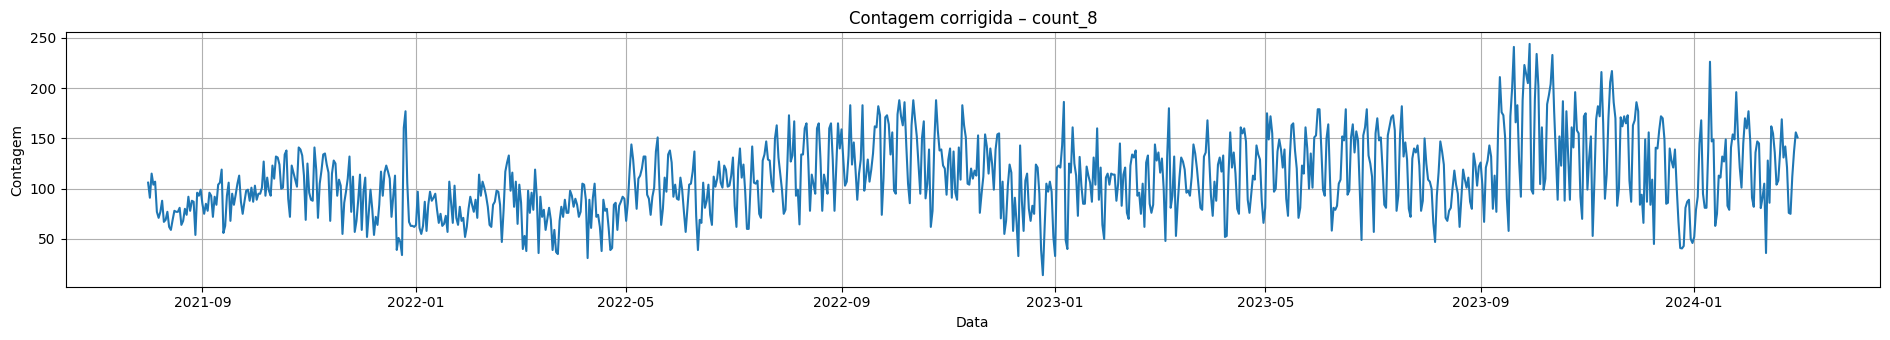

In [20]:

plt.figure(figsize=(19, 3.5))  

plt.plot(df_corrigido_final.index, df_corrigido_final[contador_id], label=contador_id)
plt.title(f"Contagem corrigida – {contador_id}")
plt.xlabel("Data")
plt.ylabel("Contagem")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
#df_corrigido_final.to_csv('df_corrigido_final.csv', index=True)


# Com a decomposição STL

In [22]:
y = df_corrigido_final['count_8']
y_boxcox = boxcox(y, lmbda=0)
best_lambda = boxcox_lambda(y, method='guerrero', season_length=7)
y_boxcox = boxcox(y, best_lambda)

In [23]:
inv_boxcox(y_boxcox, best_lambda).round(0)

array([106.,  91., 115., 104., 107.,  77.,  71.,  77.,  88.,  67.,  69.,
        77.,  62.,  59.,  69.,  78.,  77.,  77.,  81.,  64.,  68.,  80.,
        74.,  92.,  78.,  88.,  87.,  54.,  96.,  93.,  99.,  85.,  75.,
        85.,  78.,  96.,  93.,  72.,  92.,  84., 104., 106., 119.,  56.,
        63.,  93., 106.,  68.,  95.,  84.,  94., 105., 113.,  87.,  75.,
        87.,  98.,  99.,  88., 101.,  87., 103.,  89.,  95.,  95., 101.,
       127.,  93., 111.,  98.,  93., 123., 110., 132., 131., 124., 100.,
       101., 134., 138.,  90.,  72., 123., 116., 109., 102., 141., 139.,
       133., 113.,  69., 125.,  96.,  89.,  88., 141., 119.,  71., 105.,
       118., 134., 135., 124., 116.,  68., 115., 128., 125.,  93., 109.,
       103.,  55.,  86.,  97., 110., 132.,  77., 112.,  57.,  68.,  89.,
       114.,  59.,  97., 111.,  52.,  76.,  99.,  80.,  54.,  72.,  64.,
        84., 117.,  93., 116., 123., 117., 110.,  72.,  93., 113.,  39.,
        51.,  47.,  34., 160., 177., 106.,  67.,  6

In [24]:
stl = STL(y_boxcox, period=7)
decomp_stl = stl.fit()
df_decomp_stl = pd.DataFrame({
    'observed': inv_boxcox(decomp_stl.observed, best_lambda),
    'trend': inv_boxcox(decomp_stl.trend, best_lambda),
    'seasonal': inv_boxcox(decomp_stl.seasonal, best_lambda),
    'residual': inv_boxcox(decomp_stl.resid, best_lambda)
}, index=df_corrigido_final.index)

df_decomp_stl.head(15)

,observed,trend,seasonal,residual
detected,,,,
2021-08-01,106.000168,108.003988,0.999500,1.000212
2021-08-02,91.000214,102.713977,1.000253,0.997709
2021-08-03,115.000008,97.815446,1.001012,1.001506
2021-08-04,104.000168,93.293179,1.001222,1.000582
2021-08-05,107.000084,89.126421,1.003456,0.999613
2021-08-06,76.999878,85.291393,0.997168,1.000820
2021-08-07,70.999977,81.773340,0.996818,1.000243
2021-08-08,76.999878,78.444116,1.000004,0.999615
2021-08-09,87.999878,75.468710,1.000668,1.002358


,observed,trend,seasonal,residual,seasonadjust
detected,,,,,
2021-08-01,106.000168,108.003988,0.999500,1.000212,0.981447
2021-08-02,91.000214,102.713977,1.000253,0.997709,0.885957
2021-08-03,115.000008,97.815446,1.001012,1.001506,1.175684
2021-08-04,104.000168,93.293179,1.001222,1.000582,1.114767
2021-08-05,107.000084,89.126421,1.003456,0.999613,1.200543
...,...,...,...,...,...
2024-02-25,75.000328,110.879568,0.991905,1.001177,0.676413
2024-02-26,112.000572,109.623797,1.001155,0.999167,1.021681
2024-02-27,136.999756,108.594895,1.002685,1.000511,1.261567


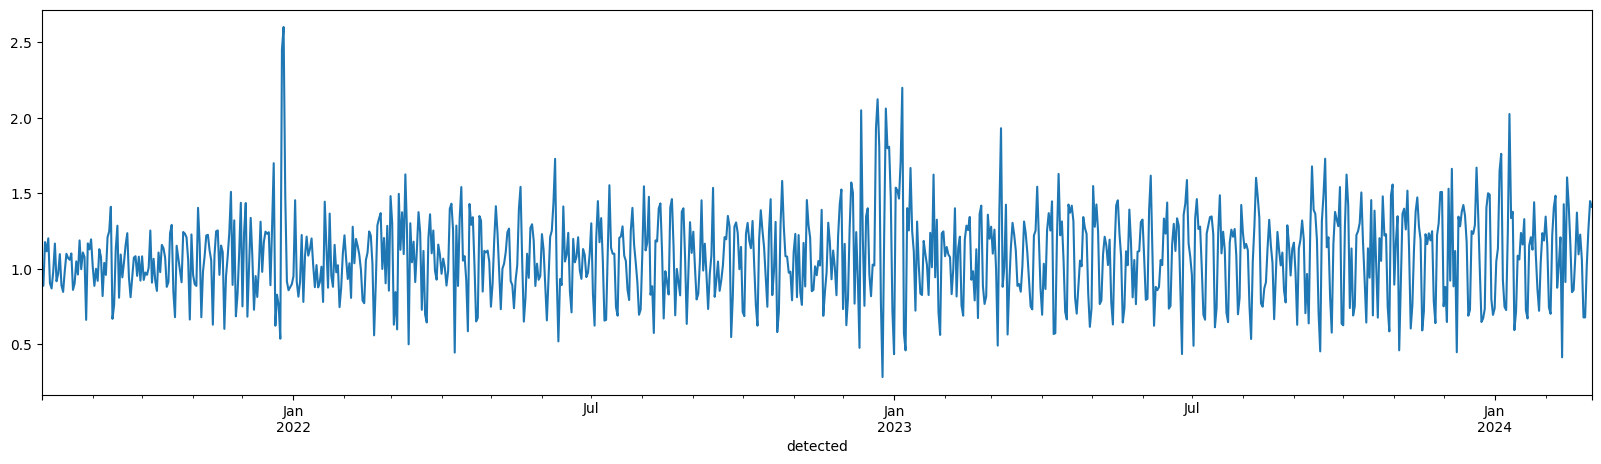

In [25]:
df_season_stl = df_decomp_stl.assign(seasonadjust = df_decomp_stl.observed / df_decomp_stl.trend)
df_season_stl.seasonadjust.plot(figsize=(20,5));
df_season_stl

### decomposição stl com janelas moveis (acrescentar uma semana)

In [26]:
def aplica_stl_boxcox(df, col='count_8', period=7):
    y = df[col].copy()
    
    # Estima lambda ótimo com método de Guerrero (necessário seasonal_length)
    best_lambda = boxcox_lambda(y, method='guerrero', season_length=period)
    
    # Aplica transformação Box-Cox
    y_boxcox = boxcox(y, lmbda=best_lambda)
    
    # Aplica STL
    stl = STL(y_boxcox, period=period, robust=True)
    decomp = stl.fit()
    
    # Reverte a transformação Box-Cox para as componentes
    def inv_boxcox(y, lmbda):
        if lmbda == 0:
            return np.exp(y)
        else:
            return np.power((y * lmbda) + 1, 1 / lmbda)
    
    df_decomp = pd.DataFrame({
        'observed': inv_boxcox(decomp.observed, best_lambda),
        'trend': inv_boxcox(decomp.trend, best_lambda),
        'seasonal': inv_boxcox(decomp.seasonal, best_lambda),
        'residual': inv_boxcox(decomp.resid, best_lambda),
    }, index=df.index)
    
    # Cria coluna ajustada pela sazonalidade
    df_decomp['seasonadjust'] = df_decomp['observed'] / df_decomp['trend']
    
    return df_decomp


In [27]:
resultados_stl = []
contador_id = 'count_8'
start_date = '2021-08-01'
end_date_inicial = '2022-07-31'
semanas_adicionadas = 0

# Janela inicial (52 semanas)
df_hist = df_corrigido_final.loc[start_date:end_date_inicial]

# 1) STL na janela inicial: guarda tudo
df_stl = aplica_stl_boxcox(df_hist, col=contador_id, period=7)
resultados_stl.append(df_stl)

while True:
    # 2) Avança 1 semana na janela móvel
    df_hist, semanas_adicionadas, conseguiu = get_one_more_week_rolling(
        df=df_corrigido_final,
        df_hist=df_hist,
        weeks_added=semanas_adicionadas,
        janela_semanas=52
    )
    if not conseguiu:
        print(f"Fim da análise para {contador_id}")
        break

    # 3) STL na nova janela móvel (52 semanas)
    df_stl_new = aplica_stl_boxcox(df_hist, col=contador_id, period=7)

    # 4) Seleciona só a última semana dos resultados (7 dias)
    ultima_semana_start = df_hist.index.max() - pd.Timedelta(days=6)
    df_stl_ultima_semana = df_stl_new.loc[ultima_semana_start:].copy()

    # 5) Acrescenta só essa última semana à coleção de resultados
    resultados_stl.append(df_stl_ultima_semana)

# 6) Junta todos os resultados para ter a série completa
df_todas_janelas = pd.concat(resultados_stl)


Fim da análise para count_8


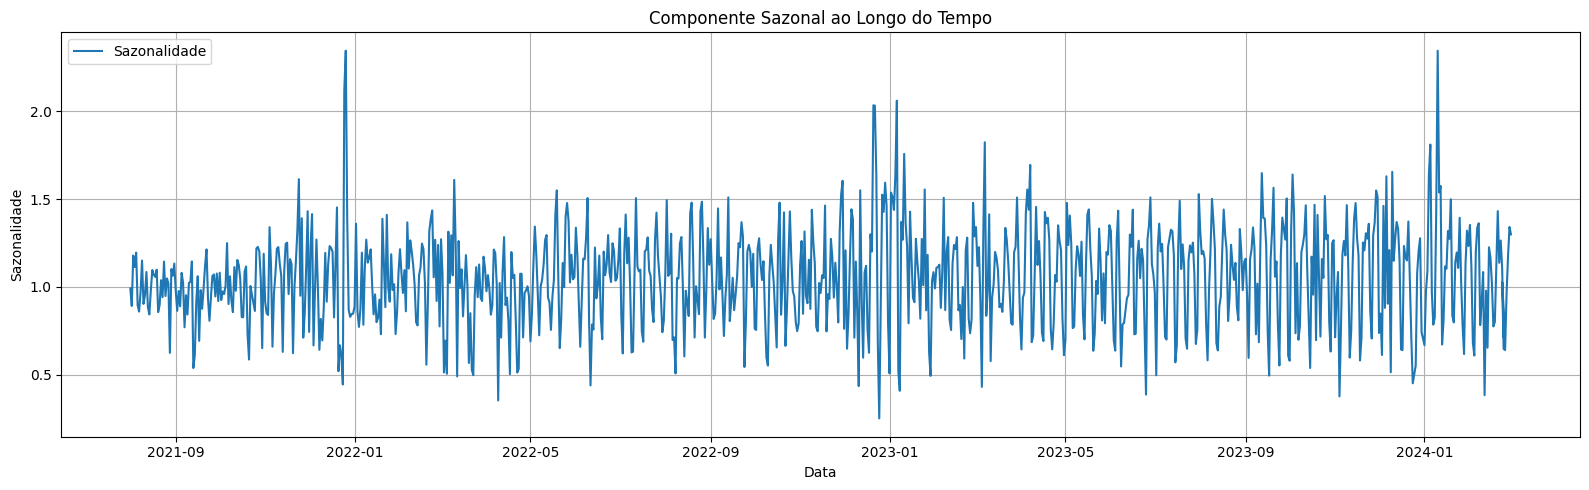

In [28]:
plt.figure(figsize=(16, 5))
plt.plot(df_todas_janelas.index, df_todas_janelas['seasonadjust'], label='Sazonalidade')
plt.title('Componente Sazonal ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Sazonalidade')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [29]:
df_corrigido_final

,direction_2,count_2,direction_3,count_3,direction_4,count_4,direction_5,count_5,direction_6,count_6,...,count_32,direction_33,count_33,direction_34,count_34,direction_35,count_35,holiday,weekend,exog
detected,,,,,,,,,,,,,,,,,,,,,
2021-08-01,219,327,155,323,138,424,238,341,539,673,...,500,401,769,354,691,526,1149,0,1,1
2021-08-02,144,252,194,381,117,372,249,364,735,907,...,486,355,590,436,777,523,1163,0,0,0
2021-08-03,151,257,187,397,137,411,321,431,732,914,...,568,441,699,376,724,584,1194,0,0,0
2021-08-04,141,266,157,337,158,423,306,404,706,890,...,563,379,626,430,799,616,1236,0,0,0
2021-08-05,159,259,182,333,121,370,257,370,740,887,...,584,367,602,424,846,636,1245,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,298,583,45,146,113,188,123,339,192,515,...,239,187,583,273,776,198,548,0,1,1
2024-02-26,226,494,290,606,193,316,281,732,357,1270,...,206,155,374,381,1214,221,608,0,0,0
2024-02-27,235,539,347,743,240,377,428,1053,433,1584,...,285,344,770,468,1368,271,780,0,0,0


# Métodos basicos 

### Funções

In [40]:
def calcular_sr_si_resample(df, coluna='count_8', plotar=True, cores=None):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # Agregar por semanas que começam à segunda-feira (W-MON)
    df_semanal = df[coluna].resample('W-MON').agg(['mean', 'max']).dropna()
    df_semanal['SR'] = df_semanal['max'] / df_semanal['mean']
    df_semanal = df_semanal.reset_index()
    
    # Extrair ano e semana ISO
    df_semanal['ano'] = df_semanal['datetime'].dt.isocalendar().year
    df_semanal['semana'] = df_semanal['datetime'].dt.isocalendar().week

    # Calcular SI por ano
    resultados_si = []
    for ano, grupo in df_semanal.groupby('ano'):
        media_sr = grupo['SR'].mean()
        max_sr = grupo['SR'].max()
        si = media_sr / max_sr if max_sr != 0 else None
        resultados_si.append({
            'ano': ano,
            'SI': round(si, 4) if si is not None else None,
            'SR_medio': round(media_sr, 4),
            'SR_max': round(max_sr, 4)
        })

    df_si = pd.DataFrame(resultados_si).sort_values('ano').reset_index(drop=True)

    if plotar:
        anos = sorted(df_semanal['ano'].unique())
        if cores is None:
            cmap = plt.cm.tab10
            cores = {ano: cmap(i % 10) for i, ano in enumerate(anos)}
        
        plt.figure(figsize=(12, 12))

        plt.subplot(3, 1, 1)
        for ano in anos:
            subset = df_semanal[df_semanal['ano'] == ano].sort_values('semana')
            plt.plot(subset['semana'], subset['SR'], marker='o', linestyle='-', label=f'Ano {ano}', color=cores[ano])
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.xlim(1, 53)
        plt.title('Seasonality Ratio (SR) por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(df_si['ano'], df_si['SI'], marker='o', color='green', label='Seasonality Indicator (SI)')
        plt.axhline(1, color='red', linestyle='--', label='SI = 1 (sem sazonalidade)')
        plt.title('Seasonality Indicator (SI) por Ano')
        plt.xlabel('Ano')
        plt.ylabel('SI')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_semanal, df_si

In [85]:
def calcular_indice_uteis_fds(df, coluna='count_8', plotar=True, cores=None):
    df = df.copy()
    df = df.set_index('datetime')

    # Separar dias úteis e não úteis com base na coluna exog
    df_uteis = df[df['exog'] != 1]
    df_nao_uteis = df[df['exog'] == 1]

    # Média semanal com resample
    media_uteis = df_uteis[coluna].resample('W-MON').mean()
    media_nao_uteis = df_nao_uteis[coluna].resample('W-MON').mean()

    # Combinar os dois em um único DataFrame
    medias = pd.concat([media_uteis, media_nao_uteis], axis=1)
    medias.columns = ['media_uteis', 'media_nao_uteis']
    medias = medias.dropna(how='all')  # remover semanas totalmente vazias

    # Calcular os índices
    medias['indice_uteis_fds'] = medias['media_uteis'] / medias['media_nao_uteis']
    medias['indice_fds_uteis'] = medias['media_nao_uteis'] / medias['media_uteis']

    # Extrair ano e semana para plotagem
    medias['ano'] = medias.index.isocalendar().year
    medias['semana'] = medias.index.isocalendar().week

    if plotar:
        anos = sorted(medias['ano'].unique())
        if cores is None:
            cmap = plt.cm.tab10
            cores = {ano: cmap(i % 10) for i, ano in enumerate(anos)}

        plt.figure(figsize=(12, 6))

        for ano in anos:
            dados_ano = medias[medias['ano'] == ano]
            plt.plot(dados_ano['semana'], dados_ano['indice_uteis_fds'],
                     marker='o', linestyle='-', label=f'Ano {ano}', color=cores[ano])

        plt.yscale('log', base=2)
        plt.axhline(1, color='red', linestyle='--', label='Índice = 1')
        plt.title('Índice: Média Úteis / Média Não Úteis (semanal, via resample)')
        plt.xlabel('Semana do Ano')
        plt.ylabel('Índice')
        plt.xlim(1, 53)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return medias


### Seasonality ratio (SR) e Seasonality Indicator (SI)

In [42]:
df_corrigido_final = df_corrigido_final.reset_index()
df_corrigido_final = df_corrigido_final.rename(columns={'detected': 'datetime'})
df_corrigido_final['datetime'] = pd.to_datetime(df_corrigido_final['datetime'])

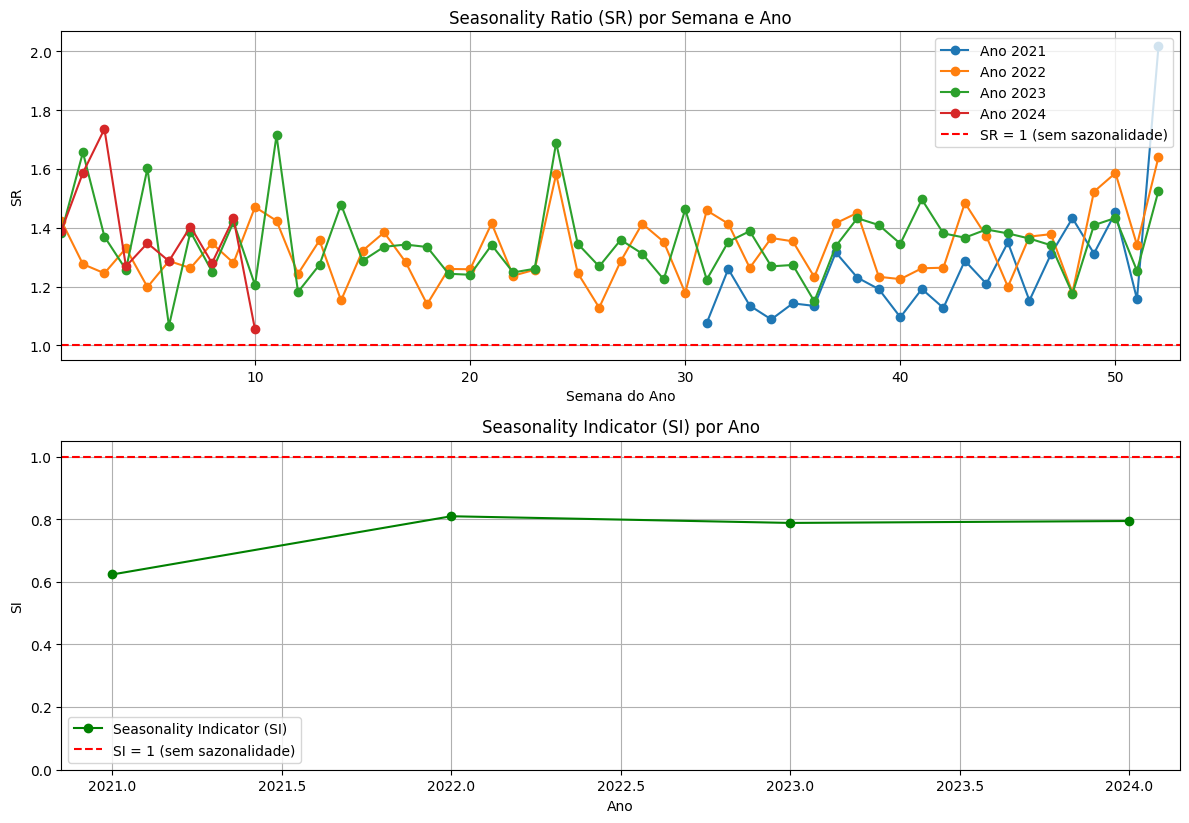

In [83]:
df_semana, df_si = calcular_sr_si_resample(df_corrigido_final, coluna='count_8', plotar=True)       

### Novo Indice

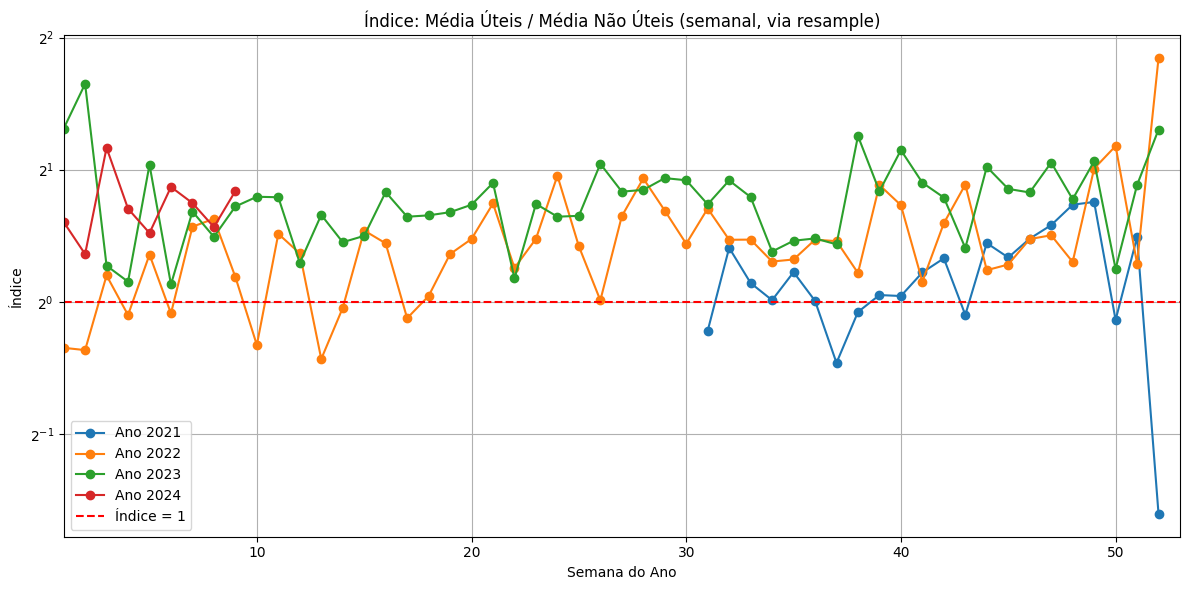

In [86]:
medias = calcular_indice_uteis_fds(df_corrigido_final, coluna='count_8', plotar=True)

### SR com stl normal

In [61]:
df_sem_tendencia = pd.DataFrame({
    'datetime': df_decomp_stl.index,
    'count_8': df_season_stl['seasonadjust']
})

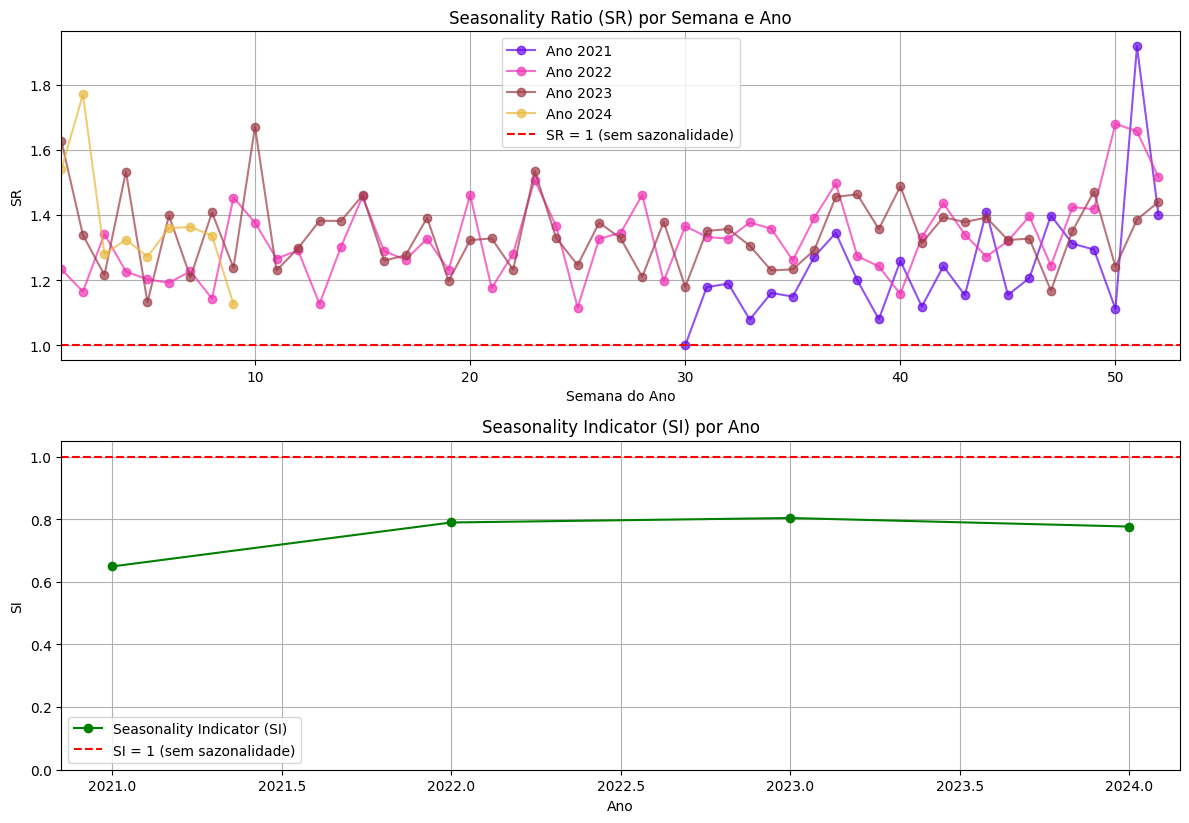

In [63]:
cores_personalizadas = {
    2021: "#6608e8",
    2022: "#f032b4",
    2023: "#9e3b46", 
    2024: "#E9B93E"
}
df_sr_ano_semana, df_sr_semana, df_si = calcular_sr_si(df_sem_tendencia, coluna='count_8', plotar=True, cores=cores_personalizadas)
#df_indices_uteis_não_uteis = calcular_indice_uteis_nao_uteis(df_sem_tendencia, coluna='count_8', plotar=True, cores=cores_personalizadas)

In [ ]:
df_stl_slidewindows = pd.DataFrame({
    'datetime': df_todas_janelas.index,
    'count_8': df_todas_janelas['seasonadjust']
})

In [ ]:
cores_personalizadas = {
    2021: "#a1c9f4",
    2022: "#9F501C",
    2023: "#68d79a", 
    2024: "#ef7785"
}
df_sr_ano_semana, df_sr_semana, df_si = calcular_sr_si(df_stl_slidewindows, coluna='count_8', plotar=True, cores=cores_personalizadas)
#df_indices_uteis_fds = calcular_indice_uteis_nao_uteis(df_stl_slidewindows, coluna='count_8', plotar=True, cores=cores_personalizadas)

### Indice de Gini

In [48]:
def gini_geometrico(valores):
    x = np.sort(np.array(valores))
    n = len(x)
    if n == 0 or np.sum(x) == 0:
        return np.nan
    y_acumulado = np.cumsum(x) / np.sum(x)
    x_lin = np.arange(1, n + 1) / n
    return (2 / n) * np.sum(x_lin - y_acumulado)



In [64]:
def gini_semanal_resample(df, coluna='count_8', plotar=True, cor='blue'):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # Agrupamento semanal regular
    grupos = df[coluna].resample('W-MON').apply(gini_geometrico).dropna()
    df_gini = grupos.reset_index()
    df_gini.rename(columns={coluna: 'gini'}, inplace=True)

    if plotar:
        plt.figure(figsize=(14, 5))
        plt.plot(df_gini['datetime'], df_gini['gini'], marker='o', color=cor)
        plt.title('Índice de Gini semanal')
        plt.xlabel('Data')
        plt.ylabel('Gini')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_gini

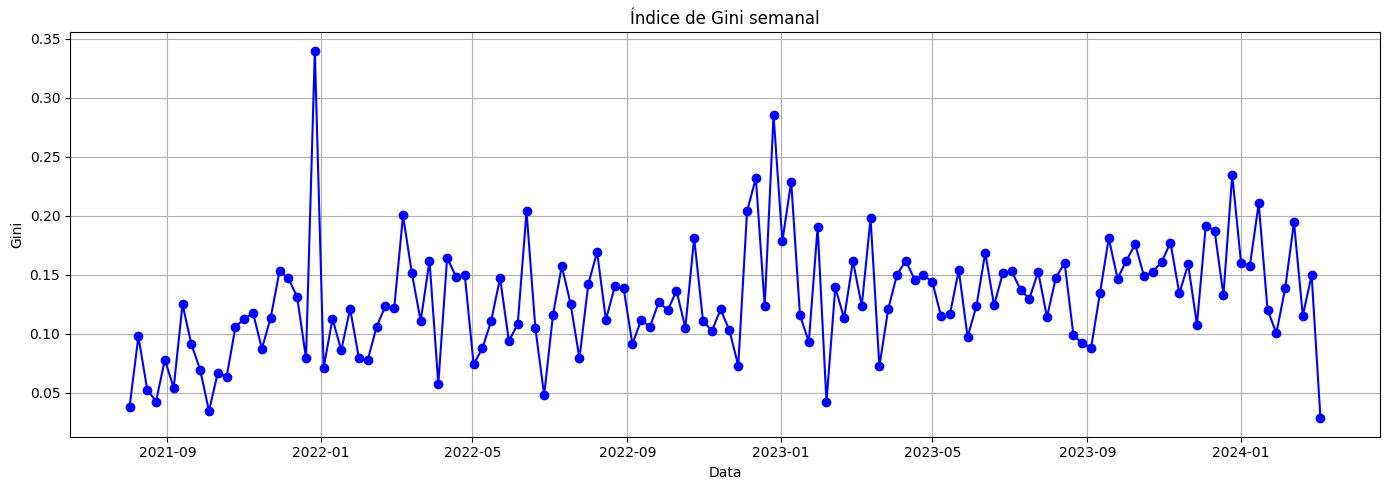

In [65]:
df_gini = gini_semanal_resample(df_corrigido_final,coluna='count_8',plotar=True)

In [ ]:
#df_gini=gini_semanal(df_sem_tendencia,coluna='count_8',plotar=True, cor='orange')

In [ ]:
#df_gini=gini_semanal(df_stl_slidewindows,coluna='count_8',plotar=True, cor='green')

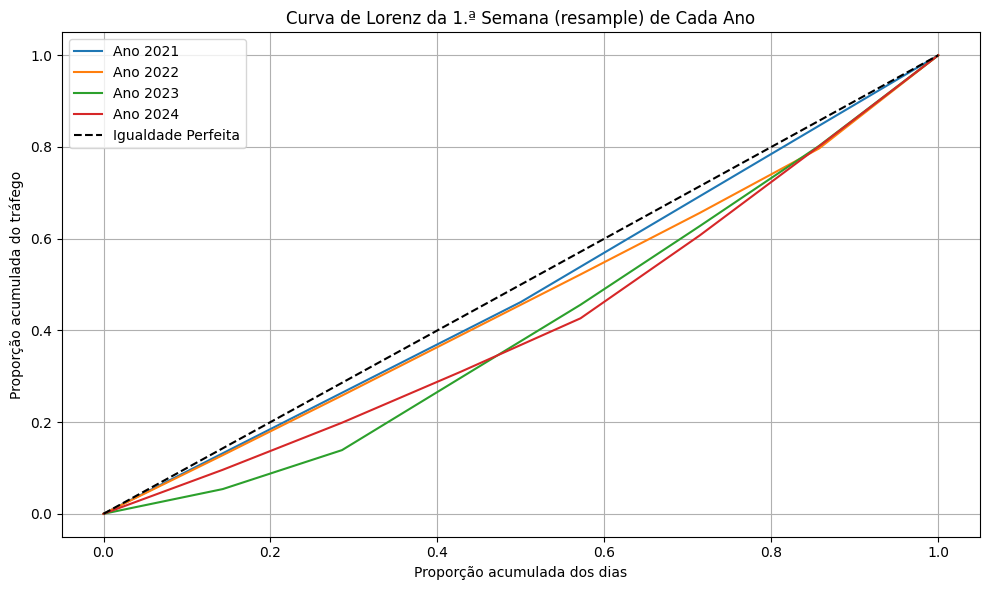

In [56]:
def curva_lorenz(valores):
    x = np.sort(np.array(valores))
    x_normalizado = x / x.sum()
    y_acumulado = np.cumsum(x_normalizado)
    y_acumulado = np.insert(y_acumulado, 0, 0)
    x_perc = np.linspace(0, 1, len(y_acumulado))
    return x_perc, y_acumulado

df = df_corrigido_final.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Criar coluna de semana-resample (com início à segunda-feira)
df['semana'] = df.index.to_period('W-MON')
df['ano'] = df.index.year

# Encontrar a primeira semana do ano para cada ano
primeiras_semanas = df.groupby('ano')['semana'].min()

plt.figure(figsize=(10, 6))

for ano, semana in primeiras_semanas.items():
    dados = df[df['semana'] == semana]['count_8']
    if len(dados) == 0:
        continue
    x_vals, y_vals = curva_lorenz(dados)
    plt.plot(x_vals, y_vals, label=f'Ano {ano}')

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Igualdade Perfeita')
plt.title('Curva de Lorenz da 1.ª Semana (resample) de Cada Ano')
plt.xlabel('Proporção acumulada dos dias')
plt.ylabel('Proporção acumulada do tráfego')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





### índice de Gini atraves da covariancia

In [57]:
def gini_covariancia(y):
    y = np.array(y)
    n = len(y)
    if n == 0 or np.sum(y) == 0:
        return np.nan

    y_sorted = np.sort(y)
    F_y = (np.arange(1, n + 1)) / n  # função de distribuição empírica (percentis)
    y_mean = np.mean(y_sorted)

    cov = np.cov(y_sorted, F_y, bias=True)[0, 1]  # covariância com bias=True para dividir por n
    gini = (2 * cov) / y_mean
    return gini

In [70]:
def gini_cov_semanal(df, coluna='count_8', plotar=True, cor='blue'):
    df = df.copy()
    df = df.set_index('datetime')

    # Calcular Gini para cada semana com resample
    df_gini_cov = (
        df[coluna]
        .resample('W-MON')  # Semanas com início à segunda-feira
        .apply(gini_covariancia)
        .reset_index(name='gini')
    )

    if plotar:
        plt.figure(figsize=(14, 5))
        plt.plot(df_gini_cov['datetime'], df_gini_cov['gini'], marker='o', color=cor)
        plt.title('Índice de Gini cov semanal ')
        plt.xlabel('Data (início da semana)')
        plt.ylabel('Gini')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_gini_cov

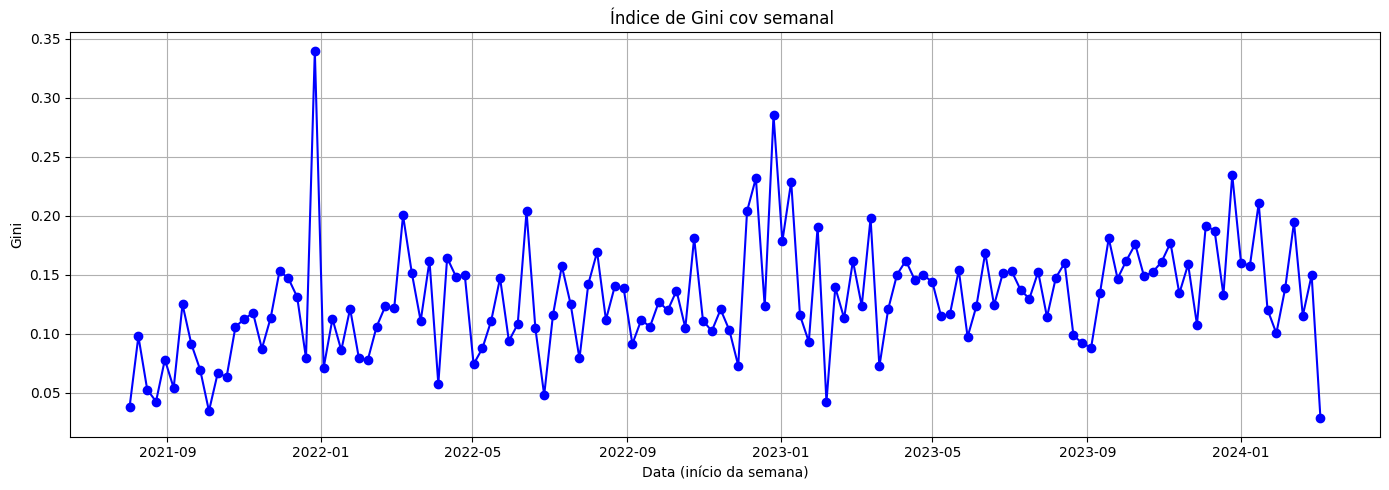

In [71]:
df_gini_cov = gini_cov_semanal(df_corrigido_final, coluna='count_8',plotar=True)

In [ ]:
#df_gini_cov = gini_cov_semanal(df_sem_tendencia, coluna='count_8',plotar=True, cor='orange')

In [ ]:
#df_gini_cov = gini_cov_semanal(df_stl_slidewindows, coluna='count_8',plotar=True, cor='green')

### Entropia

In [76]:
def entropia_semanal(df, coluna='count_8', plotar=True, data_inicio='2021-08-02', data_fim='2024-02-25'):
    from scipy.stats import entropy
    df = df.copy()
    df = df.set_index('datetime')

    data_inicio = pd.to_datetime(data_inicio)
    data_fim = pd.to_datetime(data_fim)
    df = df[(df.index >= data_inicio) & (df.index <= data_fim)]

    def calcular_entropia(x):
        x = np.array(x)
        if x.sum() == 0:
            return np.nan
        p = x / x.sum()
        return entropy(p, base=np.e)

    df_entropia = (
        df[coluna]
        .resample('W-MON')
        .apply(calcular_entropia)
        .reset_index(name='entropia')
    )

    # Calcular Theil (T) e Redundância relativa (R)
    df_entropia['T'] = np.log(7) - df_entropia['entropia']
    df_entropia['R'] = df_entropia['T'] / np.log(7)

    # Ano e semana ISO
    df_entropia['ano'] = df_entropia['datetime'].dt.isocalendar().year
    df_entropia['semana'] = df_entropia['datetime'].dt.isocalendar().week

    # Remover primeira e última semanas
    df_entropia = df_entropia.sort_values('datetime').iloc[1:-1].reset_index(drop=True)

    if plotar:
        plt.figure(figsize=(12, 15))

        for i, (col, title, ylabel) in enumerate([
            ('entropia', 'Entropia por Semana e Ano', 'Entropia'),
            ('T', 'Índice de Theil T por Semana e Ano', 'T'),
            ('R', 'Redundância Relativa R por Semana e Ano', 'R')
        ]):
            plt.subplot(3, 1, i+1)
            for ano in sorted(df_entropia['ano'].unique()):
                subset = df_entropia[df_entropia['ano'] == ano]
                plt.plot(subset['semana'], subset[col], marker='o', linestyle='-', label=f'Ano {ano}', alpha=0.7)
            plt.xlim(1, 53)
            plt.title(title)
            plt.xlabel('Semana do Ano')
            plt.ylabel(ylabel)
            plt.grid(True)
            plt.legend()

        plt.tight_layout()
        plt.show()

    return df_entropia




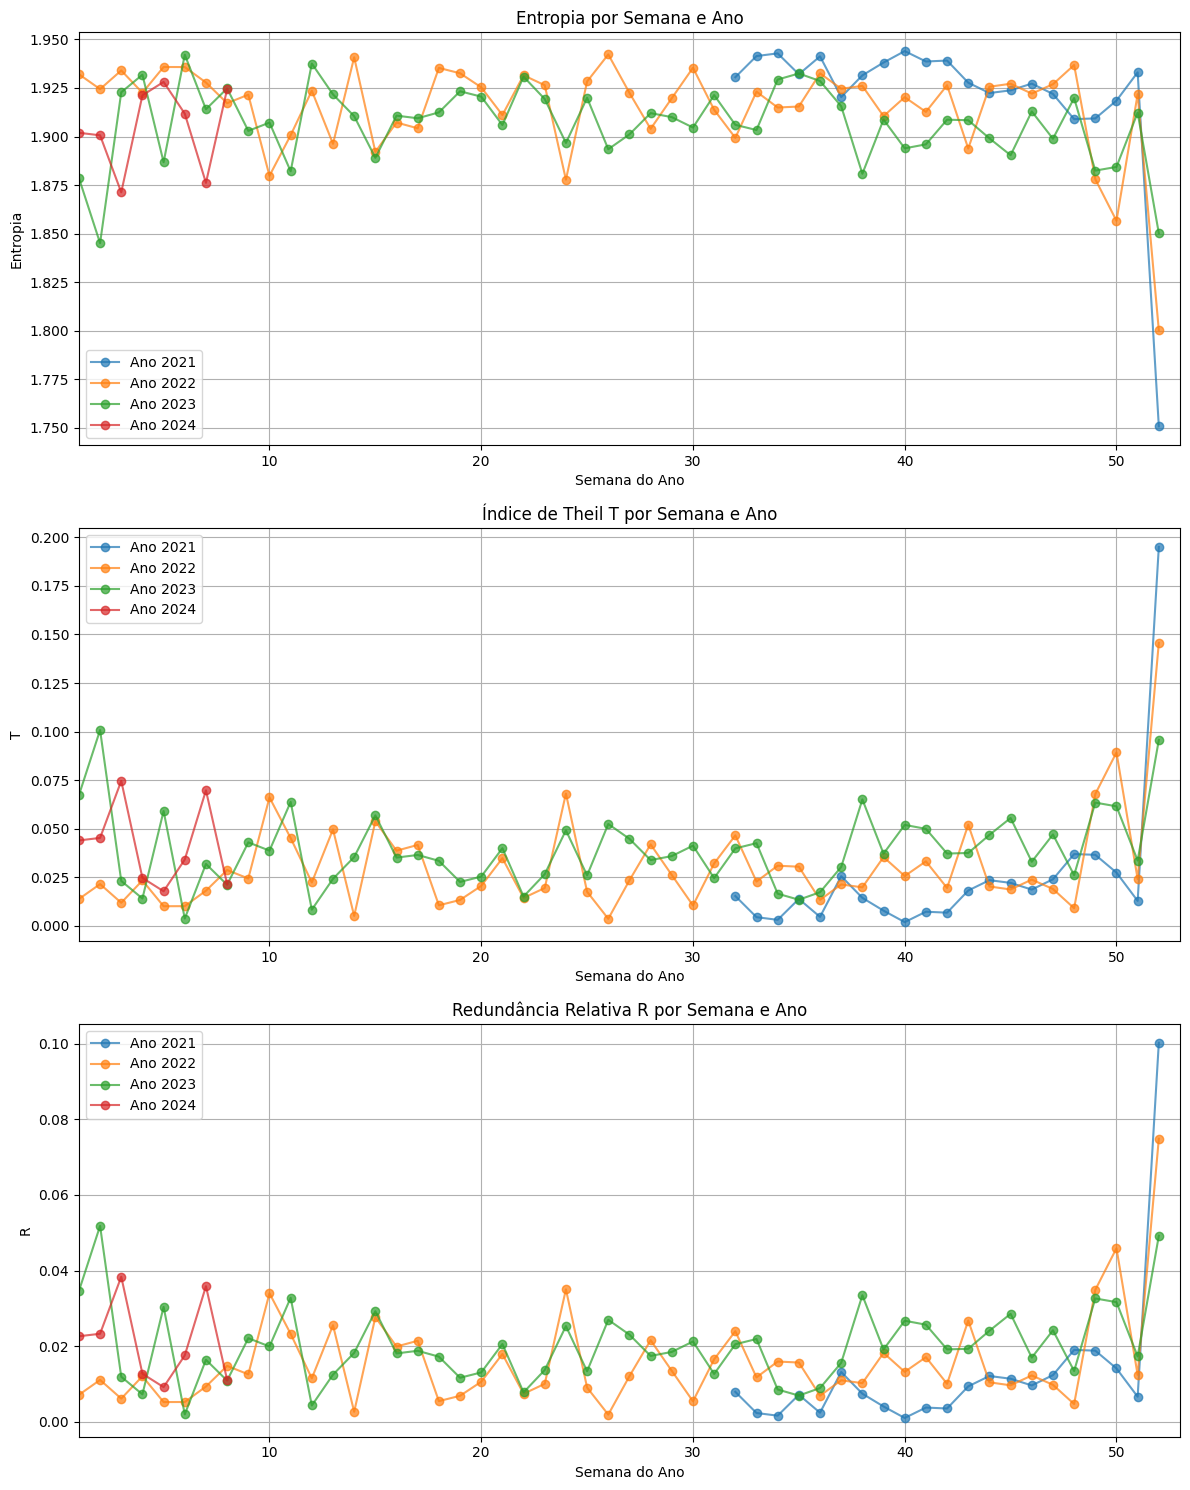

In [77]:
df_entorpia = entropia_semanal(df_corrigido_final, coluna='count_8', plotar=True )

In [78]:
print(df_entorpia['entropia'].max())
print(df_entorpia['entropia'].min())


1.9439630615746881
1.7508650516217774


In [79]:
df_entorpia.loc[df_entorpia['entropia'].idxmax()]


datetime    2021-10-04 00:00:00
entropia               1.943963
T                      0.001947
R                      0.001001
ano                        2021
semana                       40
Name: 8, dtype: object

In [ ]:
cores_personalizadas = {
    2021: "#a1c9f4",
    2022: "#9F501C",
    2023: "#68d79a", 
    2024: "#ef7785"
}
df_entorpia = entropia_semanal(df_sem_tendencia, coluna='count_8', plotar=True)

In [ ]:
# Calcular número de dias por semana
dias_por_semana = df_stl_slidewindows.groupby(['ano', 'semana']).size().reset_index(name='dias_disponiveis')

# Filtrar apenas semanas com 7 dias
semanas_validas = dias_por_semana[dias_por_semana['dias_disponiveis'] == 7][['ano', 'semana']]

# Juntar com o df original
df_stl_slidewindows = df_stl_slidewindows.merge(semanas_validas, on=['ano', 'semana'])


In [ ]:
df_entorpia = entropia_semanal(df_stl_slidewindows, coluna='count_8', plotar=True )

### Força da sazonalidade

In [ ]:
Var_X = np.var(df_decomp_stl.observed / df_decomp_stl.trend)
Var_Y = np.var(decomp_stl.resid)
forca_sazonal = 1 - (Var_Y / Var_X)
print(f"Força da sazonalidade (count_8): {forca_sazonal:.4f}")

In [ ]:
# tamanho da janela em dias
window_size = 14

# Lista para armazenar datas e forças semanais
forcas = []
datas = []

# Loop pelas janelas móveis
for i in range(len(df_decomp_stl) - window_size + 1):
    janela = df_decomp_stl.iloc[i:i + window_size]
    
    var_x = np.var(janela.observed / janela.trend)
    var_y = np.var(janela.residual)
    
    if var_x > 0:
        f = 1 - (var_y / var_x)
        forcas.append(f)
        datas.append(janela.index[window_size // 2])  # centro da janela

# Criar DataFrame com os resultados
df_forca_temp = pd.DataFrame({
    'data': datas,
    'forca_sazonal': forcas
})

# Plot
plt.figure(figsize=(14,5))
plt.plot(df_forca_temp['data'], df_forca_temp['forca_sazonal'], marker='o', linestyle='-')
plt.title('Evolução da força da sazonalidade semanal (janelas móveis)')
plt.xlabel('Data')
plt.ylabel('Força da sazonalidade')
plt.grid(True)
plt.tight_layout()
plt.show()

